In [1]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn as nn
import torch_geometric as pyg
import torch_geometric.nn as gnn

/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style('darkgrid')
np.random.seed(42)

# Dataset

In [3]:
def get_data(cell_type, subset=True, gene_list=None, seed=42):
    np.random.seed(seed)
    
    # Get graph
    data_folder = './data/training_matrices_DGL/'
    mat = pd.read_csv(data_folder + f'{cell_type}.feat.mat', index_col=0, sep='\t')
    genes = np.array(mat.columns)
    assert (genes == np.array(mat.index)).all()

    # Get labels
    meta = pd.read_csv(data_folder + 'training_labels.txt', index_col=0, sep='\t')
    labels = meta.values[:, 0]
    labels = np.array([str(meta.loc[g]['label']) if g in meta.index else 'unknown' for g in genes])

    ### SUBSET
    if gene_list is not None:
        subset_idx = np.argwhere([g in gene_list for g in genes]).flatten()
    elif subset:
        # subset_idx = np.random.choice(len(labels), 1000, replace=False)
        ad_labels = np.argwhere(labels == 'AD').flatten()
        notad_labels = np.argwhere(labels == 'notAD').flatten()
        unknown_labels = np.argwhere(labels == 'unknown').flatten()
        subset_idx = np.concatenate([
            np.random.choice(ad_labels, min(len(ad_labels), 750), replace=False),
            np.random.choice(notad_labels, min(len(notad_labels), 750), replace=False),
            np.random.choice(unknown_labels, min(len(unknown_labels), 750), replace=False)])
    mat = mat.iloc[subset_idx, subset_idx]
    genes = genes[subset_idx]
    labels = labels[subset_idx]
    ###

    # Sort labels
    ad_labels = np.argwhere(labels == 'AD').flatten()
    notad_labels = np.argwhere(labels == 'notAD').flatten()
    unknown_labels = np.argwhere(labels == 'unknown').flatten()
    known_labels = np.array(list(set(range(len(genes))) - set(unknown_labels)))

    # Split into training and testing
    train_num = int(len(genes) * .8)
    val_num = len(genes) - train_num
    train_idx = np.random.choice(len(genes), train_num, replace=False)
    val_idx = np.array(list(set(range(len(genes))) - set(train_idx)))

    # Masks
    train_mask = [i in train_idx for i in range(len(genes))]
    val_mask = [i in val_idx for i in range(len(genes))]

    # Format sparse
    mat.values[np.eye(mat.values.shape[0] ,dtype=bool)] = 0  # Remove diagonal
    mat = scipy.sparse.coo_matrix(mat.values)
    edge_indices = np.stack([mat.row, mat.col])
    edge_indices = np.concatenate([edge_indices, edge_indices[::-1]], axis=1)  # Make undirected
    edge_weights = np.concatenate([mat.data, mat.data])

    # Construct dataset
    data = pyg.data.Data(
        num_nodes=len(labels),
        node_name=genes,
        y=labels,
        edge_index=torch.tensor(edge_indices).to(torch.int64),
        edge_weight=torch.tensor(edge_weights).to(torch.float64),
        train_mask=train_mask,
        val_mask=val_mask)
    
    return (data, genes), (train_idx, val_idx), (labels, ad_labels, notad_labels, unknown_labels, known_labels)

# Example dataset
# from torch_geometric.datasets import Planetoid
# dataset = Planetoid('./data', 'Cora')[0]
# dataset
# row, col = data.edge_index
# print(col.dtype)
# row, col = dataset.edge_index
# print(col.dtype)

# Embedding Model

In [4]:
# Train model
def train(model, loader, optimizer):
    epoch_loss = 0
    for pos, neg in loader:
        loss = model.loss(pos, neg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()
        
    return epoch_loss / len(loader)

# AD Prediction

In [5]:
# Create model
class FCL(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fcl = nn.Linear(self.input_dim, self.output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X):
        return self.sigmoid(self.fcl(X))

# Train model
def train_ad(ad_model, ad_optimizer, ad_criterion, z):
    batch_size = 128
    batches = data.edge_index.shape[1] // batch_size
    epoch_loss = 0
    for j in range(batches):
        seg_size = int(batch_size / 2)
        ad_batch_idx = np.random.choice(np.intersect1d(ad_labels, train_idx), seg_size, replace=True)
        notad_batch_idx = np.random.choice(np.intersect1d(notad_labels, train_idx), seg_size, replace=True)
        batch_idx = np.concatenate([ad_batch_idx, notad_batch_idx])

        true = torch.cat([torch.ones((seg_size, 1)), torch.zeros((seg_size, 1))])
        logits = ad_model(z[batch_idx])
        loss = ad_criterion(logits, true)
        loss.backward()
        ad_optimizer.step()
        epoch_loss += loss.detach()
    epoch_loss /= batches
    
    return epoch_loss

# Training

In [6]:
def generate_models():
    # Construct model
    embedding_dim = 16
    model = gnn.Node2Vec(
        data.edge_index,
        embedding_dim=embedding_dim,
        walk_length=20,
        context_size=10,
        walks_per_node=10,
        num_negative_samples=1,
        p=1,
        q=1,
        num_nodes=len(data.y),
        sparse=True)
    loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
    optimizer = torch.optim.SparseAdam(model.parameters(), lr=1e-2)

    # Train embeddings
    print('Generating embeddings...')
    model.train()
    for i in range(21):
        epoch_loss = train(model, loader, optimizer)
        if i % 2 == 0:
            print(f'Epoch {i} Loss: {epoch_loss:.3f}')
    model.eval()

    # Construct AD Model (NN)
    ad_model = FCL(embedding_dim)
    ad_optimizer = torch.optim.Adam(ad_model.parameters(), lr=1e-2)
    ad_criterion = nn.MSELoss()

    # Train AD Model (NN)
    print('Training AD classification model...')
    z = model()
    ad_model.train()
    for i in range(61):
        epoch_loss = train_ad(ad_model, ad_optimizer, ad_criterion, z)
        if i % 10 == 0:
            print(f'Epoch {i} Loss: {epoch_loss:.3f}')
    ad_model.eval()
    
    # # Construct AD Model (Logistic Regression)
    # z = model().detach().numpy()
    # ad_model = LogisticRegression(solver='lbfgs', multi_class='auto').fit(
    #     z[np.intersect1d(np.union1d(ad_labels, notad_labels), train_idx)],
    #     np.concatenate([np.ones(len(np.intersect1d(ad_labels, train_idx))), np.zeros(len(np.intersect1d(notad_labels, train_idx)))]))
    
    return model, ad_model

# Results

In [7]:
def preview_ad():
    # Predictions
    pred_val = ad_model(model())
    pred = np.array(['AD' if ad else 'notAD' for ad in (pred_val > .5)])

    # Printout
    print('GENE\tPRED\tVALUE\tTRUE')
    for i in np.random.choice(np.intersect1d(ad_labels, val_idx), 10, replace=True):
        print(f'{genes[i]}\t{pred[i]}\t{float(pred_val[i].detach()):.3f}\tAD')
    print()
    print('GENE\tPRED\tVALUE\tTRUE')
    for i in np.random.choice(np.intersect1d(notad_labels, val_idx), 10, replace=True):
        print(f'{genes[i]}\t{pred[i]}\t{float(pred_val[i].detach()):.3f}\tnotAD')
    print()
    print('GENE\tPRED\tVALUE\tTRUE')
    for i in np.random.choice(unknown_labels, 10, replace=True):
        print(f'{genes[i]}\t{pred[i]}\t{float(pred_val[i].detach()):.3f}\tunknown')

def write_predictions(prefix='./'):
    # Predictions
    pred_val = ad_model(model())
    pred = np.array(['AD' if ad else 'notAD' for ad in (pred_val > .5)])
    
    # Write enrichment genes to files
    ad_enrichment = genes[np.intersect1d(np.argwhere(pred == 'AD'), val_idx)]
    notad_enrichment = genes[np.intersect1d(np.argwhere(pred == 'notAD'), val_idx)]
    np.savetxt(prefix + 'AD.txt', ad_enrichment, fmt='%s')
    np.savetxt(prefix + 'notAD.txt', notad_enrichment, fmt='%s')

In [8]:
def get_auroc():
    # Predictions
    pred_val = ad_model(model())
    
    # ROC
    eval_idx = np.intersect1d(val_idx, known_labels)
    fpr, tpr, thresholds = roc_curve(1.*(labels[eval_idx] == 'AD'), pred_val[eval_idx].detach())
    
    return auc(fpr, tpr)

def plot_roc():
    # Predictions
    pred_val = ad_model(model())
    
    # ROC Curve
    eval_idx = np.intersect1d(val_idx, known_labels)
    fpr, tpr, thresholds = roc_curve(1.*(labels[eval_idx] == 'AD'), pred_val[eval_idx].detach())
    plt.plot(fpr, tpr)
    plt.title(f'ROC Curve ({auc(fpr, tpr)})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

# Runtime

In [9]:
cell_types = np.array([f[:-9] for f in os.listdir('./data/training_matrices_DGL') if '.mat' in f])
auroc_list = []
for i, cell_type in enumerate(cell_types):
    # Set up dir
    if not os.path.exists('results/'):
        os.mkdir('results/')
    if i == 0:
        open('results/auroc.txt', 'w').close()
    if not os.path.exists(f'results/{cell_type}'):
        os.mkdir(f'results/{cell_type}')
    results_dir = f'results/{cell_type}/'
    
    # Get data
    print(f'Loading {cell_type} data...')
    dataset = get_data(cell_type)
    data, genes = dataset[0]
    train_idx, val_idx = dataset[1]
    labels, ad_labels, notad_labels, unknown_labels, known_labels = dataset[2]
    np.savetxt(results_dir + 'genes.txt', genes, fmt='%s')
    
    # Train models
    if os.path.exists(results_dir + 'model.h5') and os.path.exists(results_dir + 'ad_model.h5'):
        print('Loading pre-trained models...')
        model = torch.load(results_dir + 'model.h5')
        ad_model = torch.load(results_dir + 'ad_model.h5')
    else:
        model, ad_model = generate_models()
        np.save(results_dir + 'embeddings.npy', model().detach().numpy())
        torch.save(model, results_dir + 'model.h5')
        torch.save(ad_model, results_dir + 'ad_model.h5')
    
    # Save results
    auroc_list.append(get_auroc())
    print(f'{cell_type} AUROC: {auroc_list[-1]:.3f}')
    write_predictions(prefix=results_dir)
    with open('results/auroc.txt', 'a') as f:
        f.write(f'{cell_type} AUROC: {auroc_list[-1]:.3f}\n')
    print()
auroc_list = np.array(auroc_list)

Loading Astrocyte data...
Loading pre-trained models...
Astrocyte AUROC: 0.593

Loading Endothelial data...
Loading pre-trained models...
Endothelial AUROC: 0.515

Loading GABAergic_neuron data...
Loading pre-trained models...
GABAergic_neuron AUROC: 0.470

Loading GABAergic_PVALB_interneuron data...
Loading pre-trained models...
GABAergic_PVALB_interneuron AUROC: 0.536

Loading GABAergic_SST_interneuron data...
Loading pre-trained models...
GABAergic_SST_interneuron AUROC: 0.637

Loading GABAergic_VIP_interneuron data...
Loading pre-trained models...
GABAergic_VIP_interneuron AUROC: 0.670

Loading Glutamatergic_neuron data...
Loading pre-trained models...
Glutamatergic_neuron AUROC: 0.521

Loading Microglia data...
Loading pre-trained models...
Microglia AUROC: 0.506

Loading Mural data...
Loading pre-trained models...
Mural AUROC: 0.477

Loading Oligodendrocyte data...
Loading pre-trained models...
Oligodendrocyte AUROC: 0.518

Loading OPC data...
Loading pre-trained models...
OPC AU

# Summary

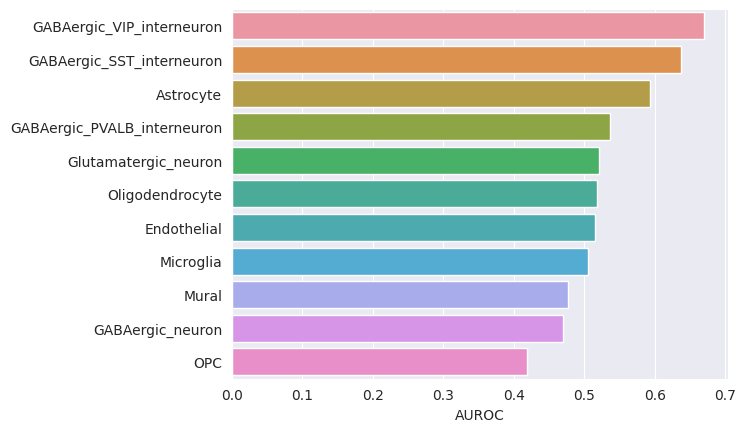

In [10]:
# Barplot
sort_idx = np.argsort(auroc_list)[::-1]
sns.barplot(x=auroc_list[sort_idx], y=cell_types[sort_idx])
plt.xlabel('AUROC');

In [11]:
# Get best model
best_performing_model = np.argmax(auroc_list)
# auroc_list = [.5] * len(cell_types)
print(f'Best performing model: {cell_types[best_performing_model]} ({auroc_list[best_performing_model]:.3f})')
cell_type = cell_types[best_performing_model]
results_dir = f'results/{cell_type}/'

Best performing model: GABAergic_VIP_interneuron (0.670)


In [26]:
def preview_graph(gene_list):
    dataset = get_data(cell_type, gene_list=gene_list)
    data, genes = dataset[0]
    train_idx, val_idx = dataset[1]
    labels, ad_labels, notad_labels, unknown_labels, known_labels = dataset[2]

    # Create graph
    graph = pyg.utils.convert.to_networkx(data, node_attrs=['node_name'], edge_attrs=['edge_weight'], to_undirected=True)
    graph = nx.relabel_nodes(graph, lambda x: graph.nodes(data=True)[x]['node_name'], copy=False)

    # Generate positions
    z = np.load(results_dir + 'embeddings.npy')
    z_genes = np.loadtxt(results_dir + 'genes.txt', dtype=str)
    # PCA
    # from sklearn.decomposition import PCA
    # pca = PCA(n_components=2).fit_transform(z[[g in gene_list for g in z_genes]])
    # UMAP
    import umap
    pca = umap.UMAP(n_components=2).fit_transform(z[[g in gene_list for g in z_genes]])
    # NONE
    # pca = z[:, :2]
    # POS
    pos = {k: v for k, v in zip([g for g in z_genes if g in gene_list], pca)}

    # Preview graph
    node_color = [(1, .5, .5, 1) if u in ad_genes else (.5, .5, 1, 1) for u in graph.nodes()]
    edge_color = [(0, 0, 0, .5*graph[u][v]['edge_weight']) for u, v in graph.edges()]
    nx.draw(graph,
            pos=pos,
            # pos=nx.nx_pydot.graphviz_layout(graph, prog='fdp'),
            # pos=nx.spring_layout(graph,
            #                      k=.5,  # (1/np.sqrt(len(graph.nodes())))*5,
            #                      weight='edge_weight',
            #                      seed=42),
            node_color=node_color,
            node_size=10,
            edge_color=edge_color,
            width=.2)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color=(1, .3, .3, 0), label='AD', markerfacecolor=(1, .5, .5, 1), markersize=10),
    Line2D([0], [0], marker='o', color=(.3, .3, 1, 0), label='Not AD', markerfacecolor=(.5, .5, 1, 1), markersize=10)]
# Genes
ad_genes = np.loadtxt(results_dir + 'AD.txt', dtype=str)
notad_genes = np.loadtxt(results_dir + 'notAD.txt', dtype=str)

# Nodes: 324


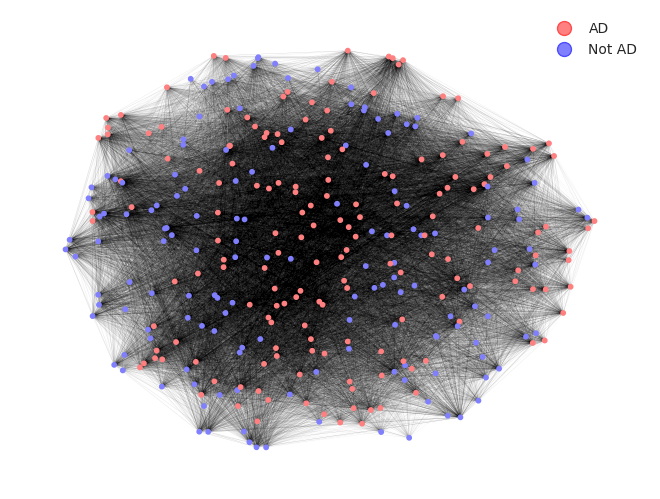

In [30]:
# Preview eval subset
gene_list = np.array(list(ad_genes) + list(notad_genes))
print(f'# Nodes: {len(gene_list)}')
preview_graph(gene_list)
plt.legend(handles=legend_elements, loc='upper right', fancybox=True, framealpha=0.);

# Nodes: 170


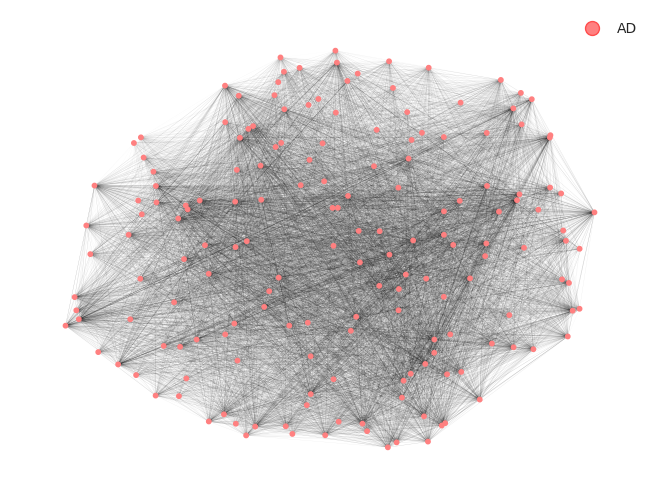

In [31]:
# Preview AD predicted
gene_list = ad_genes
print(f'# Nodes: {len(gene_list)}')
preview_graph(gene_list)
plt.legend(handles=legend_elements[:1], loc='upper right', fancybox=True, framealpha=0.);

# Nodes: 154


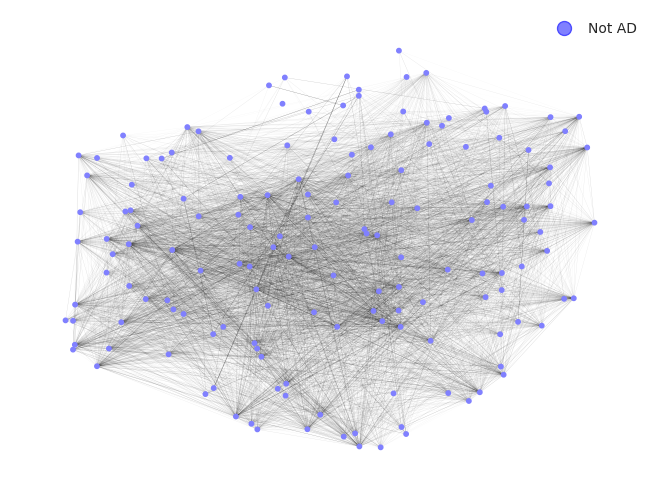

In [32]:
# Preview notAD predicted
gene_list = notad_genes
print(f'# Nodes: {len(gene_list)}')
preview_graph(gene_list)
plt.legend(handles=legend_elements[1:], loc='upper right', fancybox=True, framealpha=0.);